In [1]:
import time
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelBinarizer

In [3]:
shift = 4320
shift_lbp = 26

In [4]:
hog_features = 'C:\\Users\\rafae\\Desktop\\Coleta\\features\\features_hog_*.csv'
lbp_features = 'C:\\Users\\rafae\\Desktop\\Coleta\\features\\features_lbp_*.csv'

In [5]:
hog_files_list = glob.glob(hog_features)
print(len(hog_files_list))

lbp_files_list = glob.glob(lbp_features)
print(len(lbp_files_list))

513
513


In [6]:
# read features
frames = [pd.read_csv(f, header=0) for f in hog_files_list ]
len(frames)

# read features
lbp = [pd.read_csv(f, header=0) for f in lbp_files_list ]
len(lbp)

513

In [7]:
ds = pd.concat(frames)
ds_lbp = pd.concat(lbp)

In [8]:
print(ds.shape, ds_lbp.shape)

(7680, 17282) (7680, 106)


In [9]:
ds.head()

,0,1,2,3,4,5,6,7,8,9,...,17272,17273,17274,17275,17276,17277,17278,17279,17280,17281
0,1,p002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.071793,0.090339,0.127822,0.127822,0.042653,0.053141,0.059538,0.003019,0.019839,0.127822
1,1,p002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.069514,0.119957,0.119957,0.119957,0.024254,0.051084,0.053452,0.014108,0.010533,0.119957
2,1,p002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.103166,0.037546,0.044686,0.122575,0.033838,0.104095,0.087389,0.003405,0.009884,0.017647
3,1,p002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.132490,0.091092,0.132490,0.123109,0.038147,0.132490,0.132490,0.050142,0.042432,0.028560
4,1,p002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.052366,0.038015,0.034714,0.061695,0.040908,0.070168,0.032586,0.004734,0.009425,0.023819


In [10]:
ds_lbp.head()

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,105
0,1,p002,0.020651,0.014532,0.015844,0.012784,0.009943,0.016499,0.015188,0.017920,...,0.018029,0.021416,0.011691,0.012019,0.010599,0.009943,0.013221,0.014751,0.045892,0.235468
1,1,p002,0.017373,0.017045,0.014532,0.013003,0.011910,0.012128,0.011473,0.011910,...,0.018466,0.019777,0.011145,0.011582,0.011254,0.010599,0.010927,0.015188,0.048733,0.236233
2,1,p002,0.020542,0.014969,0.011582,0.013986,0.012566,0.014095,0.014423,0.015406,...,0.017373,0.018684,0.010490,0.012238,0.012456,0.010599,0.012566,0.014969,0.050153,0.231206
3,1,p002,0.022509,0.014095,0.013658,0.012456,0.011364,0.011801,0.010380,0.018138,...,0.019122,0.019777,0.010271,0.012456,0.011145,0.010052,0.014642,0.013330,0.052557,0.228475
4,1,p002,0.019012,0.011364,0.015406,0.012675,0.011254,0.014095,0.015188,0.017045,...,0.017373,0.020323,0.012675,0.011364,0.012893,0.012019,0.012893,0.015079,0.049934,0.220061


In [11]:
# convert points do binary Eyes ON or OFF Road
on_road_points = [13, 14, 16, 17]
on_off_road_bit = np.where(ds['0'].isin(on_road_points), 1,0)
print(ds['0'].isin(on_road_points).value_counts())

False    6105
True     1575
Name: 0, dtype: int64


In [12]:
yData = on_off_road_bit

In [25]:
xData = pd.concat([ds.iloc[:,2+shift:2+shift+shift], ds_lbp.iloc[:,2:2+shift_lbp]], axis=1)

In [26]:
xData.shape

(7680, 4346)

In [27]:
yData[20]

0

In [28]:
print(yData.shape, xData.shape, type(yData), type(xData))

(7680,) (7680, 4346) <class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>


In [29]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, rotation=45)
    plt.yticks(tick_marks)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn import cross_validation

# Compute confusion matrix
def plot_confusion(yTest, yTestPred, name):
    cm = confusion_matrix(yTest, yTestPred)
    np.set_printoptions(precision=2)

    # Normalize the confusion matrix by row (i.e by the number of samples in each class)
    cm_normalized = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100
    print('Classification report')
    print(classification_report(yTest, yTestPred))
    print('Normalized confusion matrix')
    print(cm_normalized)
    plt.figure(figsize=(5, 5))
    plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix (%s)' % (name))

    plt.show()
    # plot confusion matrix

In [31]:
from sklearn.metrics import make_scorer,precision_recall_fscore_support

def search(X_train, X_test, y_train, y_test, group_data_train):
    
    # normalize data
    print("Normalizing data!")
    stdScale = preprocessing.StandardScaler().fit(X_train)
    xTrain = stdScale.transform(X_train)
    xTest = stdScale.transform(X_test)
    
    print("Grid Search Classifiers!")
    
    knc = KNeighborsClassifier()
    svc = SVC()
    rfc = RandomForestClassifier()
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
    clf1 = SVC()
    clf2 = RandomForestClassifier(random_state=1)
    clf3 = GaussianNB()
    vt = VotingClassifier(estimators=[('svc', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

    kncp = [{'n_neighbors': [3, 5, 7, 10],
             'weights': ['uniform','distance'],
              'algorithm': ['auto','kd_tree']}]
    svcp = [{'kernel': ['rbf'], #{'kernel': ['rbf','linear'], 
             'class_weight':['balanced'],
             'gamma': ['auto',0.1, 0.001, 0.0001], #'gamma': [0.0001],#
             'C': [0.001, 0.01, 0.1, 1.0, 1, 10, 50, 100]}]#'C': [1000]}]#
    rfcp = [{'n_estimators': [10, 20, 50, 100,200], 
            'max_features': ['auto', 'log2'],
            'max_depth': [None],
            'bootstrap': [True, False],
            'criterion': ["gini", "entropy"]}]
    gbp = [{#'loss' : ['deviance', 'exponential'],
           'n_estimators': [10, 50,100, 200],
           'learning_rate': [0.001, 0.01, 0.1, 1.0,10],
           'max_features': ['auto', 'log2'],
           'max_depth' : [3,5,10, 100]
            }]
           #'min_impurity_decrease': [0.0]}]#, 0.1]}]
    vtp = [{'svc__C': [1.0, 100.0], 
            'rf__n_estimators': [20, 200],}]
   
    classifiers = [('kNN', knc, kncp),                                 
                    ('Support Vector', svc, svcp),
                    ('Random Forest', rfc, rfcp),
                    ('Gradient Boosting', gb, gbp),
                    ('Vooting', vt, vtp)
    ]
    
    for name, classifier, params in classifiers:
        print(name)
        clf = GridSearchCV(classifier, params,n_jobs=4, cv=5, scoring=['f1_weighted','accuracy','precision_weighted', 'recall_weighted'], refit='f1_weighted' , verbose = 10)

        clf.fit(X_train, y_train, groups=group_data_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print(clf.best_score_)
        print()
        print(clf.cv_results_.keys())
        means = clf.cv_results_['mean_test_accuracy']
        stds = clf.cv_results_['std_test_accuracy']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        yTrue, yPred = y_test, clf.predict(X_test)
        print(classification_report(yTrue, yPred))
        plot_confusion(yTrue, yPred, name)
        print()

In [32]:
le = preprocessing.LabelEncoder()
le.fit(yData)
print(le.classes_)
yDataBin = le.transform(yData)

[0 1]


<class 'numpy.ndarray'> (5131,) (2549,)
TRAIN: [   0    1    2 ..., 7677 7678 7679] TEST: [ 570  571  572 ..., 7407 7408 7409]
['p002' 'p003' 'p005' 'p006' 'p008' 'p009' 'p011' 'p012' 'p013' 'p015'
 'p019' 'p020' 'p021' 'p022' 'p023' 'p024' 'p026' 'p027' 'p029' 'p033']
['p004' 'p007' 'p014' 'p016' 'p025' 'p028' 'p030' 'p031' 'p032']
0    4081
1    1050
Name: 0, dtype: int64
0    2024
1     525
Name: 0, dtype: int64


Normalizing data!
Grid Search Classifiers!
kNN
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed: 82.9min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 124.6min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 207.3min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 251.2min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 375.8min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 459.8min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 582.9min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 669.4min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed: 845.1min finished


Best parameters set found on development set:

{'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'}

Grid scores on development set:
0.72709591969

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_algorithm', 'param_n_neighbors', 'param_weights', 'params', 'split0_test_f1_weighted', 'split1_test_f1_weighted', 'split2_test_f1_weighted', 'split3_test_f1_weighted', 'split4_test_f1_weighted', 'mean_test_f1_weighted', 'std_test_f1_weighted', 'rank_test_f1_weighted', 'split0_train_f1_weighted', 'split1_train_f1_weighted', 'split2_train_f1_weighted', 'split3_train_f1_weighted', 'split4_train_f1_weighted', 'mean_train_f1_weighted', 'std_train_f1_weighted', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_train_accuracy', 'split1_train_accuracy', 'split2_train_accuracy', 'split3_train_accuracy', 'split4_tr

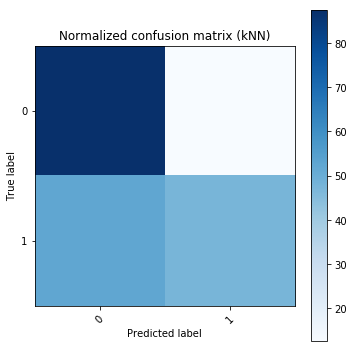


Support Vector
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed: 78.1min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 117.1min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 194.8min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 234.4min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 350.5min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 426.3min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 519.1min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 570.5min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 634.7min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 695.6min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 751.4min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 811.6min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 869.8min
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed: 1511.0min finished


Best parameters set found on development set:

{'C': 10, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}

Grid scores on development set:
0.79398922842

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_class_weight', 'param_gamma', 'param_kernel', 'params', 'split0_test_f1_weighted', 'split1_test_f1_weighted', 'split2_test_f1_weighted', 'split3_test_f1_weighted', 'split4_test_f1_weighted', 'mean_test_f1_weighted', 'std_test_f1_weighted', 'rank_test_f1_weighted', 'split0_train_f1_weighted', 'split1_train_f1_weighted', 'split2_train_f1_weighted', 'split3_train_f1_weighted', 'split4_train_f1_weighted', 'mean_train_f1_weighted', 'std_train_f1_weighted', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_train_accuracy', 'split1_train_accuracy', 'split2_train_accuracy', 'split3_train_accu

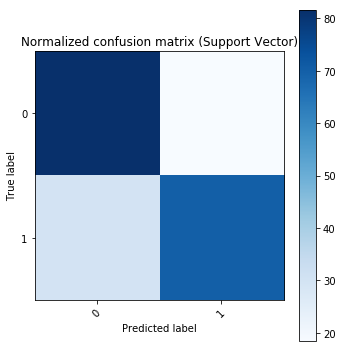


Random Forest
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   26.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   46.4s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  7.6min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 11.5min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 12.3min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 13.8min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 17.7min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 20.4min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 22.5min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed: 30.4min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 32.3min
[Parallel(n_jobs=4)]: Do

Best parameters set found on development set:

{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 10}

Grid scores on development set:
0.735600592428

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_bootstrap', 'param_criterion', 'param_max_depth', 'param_max_features', 'param_n_estimators', 'params', 'split0_test_f1_weighted', 'split1_test_f1_weighted', 'split2_test_f1_weighted', 'split3_test_f1_weighted', 'split4_test_f1_weighted', 'mean_test_f1_weighted', 'std_test_f1_weighted', 'rank_test_f1_weighted', 'split0_train_f1_weighted', 'split1_train_f1_weighted', 'split2_train_f1_weighted', 'split3_train_f1_weighted', 'split4_train_f1_weighted', 'mean_train_f1_weighted', 'std_train_f1_weighted', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_train_accuracy'

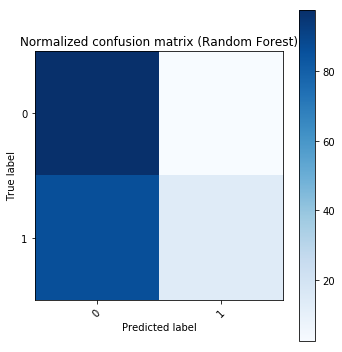


Gradient Boosting
Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 10.5min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 82.3min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 83.1min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 84.3min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 88.9min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 120.0min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 151.6min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 152.8min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 192.7min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 295.9min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 308.6min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 543.2min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 548.5min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed: 578.4min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 600.6min
[Parallel(n_jo

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit,GroupShuffleSplit
from scipy import stats

#gss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=0)
gss = GroupShuffleSplit(n_splits=2, test_size=0.3, random_state=0)

for train_index, test_index in gss.split(xData, yDataBin, groups=ds['1']):
    print(type(train_index), train_index.shape, test_index.shape)
    print("TRAIN:", train_index, "TEST:", test_index)
    print(np.unique(ds.iloc[train_index,1]))
    print(np.unique(ds.iloc[test_index,1]))
    dt = pd.DataFrame(yDataBin[train_index])
    print(dt[0].value_counts())
    dte = pd.DataFrame(yDataBin[test_index])
    print(dte[0].value_counts())
    print()
    print()
    
    search(xData.iloc[train_index,:], xData.iloc[test_index,:], 
           yDataBin[train_index], yDataBin[test_index], 
           ds.iloc[train_index,1])

In [ ]:
print(type(r), len(r))

In [ ]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(xData, yDataBin, test_size=0.3, random_state=0, stratify=[ds['1'], ds['0']])

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape,
      type(X_train.shape), type(X_test.shape), type(y_train.shape), type(y_test.shape))

In [ ]:
X_train['1'].unique()

In [ ]:
X_test['1'].unique()

In [ ]:
search(X_train, X_test, y_train, y_test)

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = le.classes_
# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='rbf', C=10, gamma=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
tic = time.clock()
y = classifier.predict(X_test[-1:])
print(time.clock() - tic)

In [ ]:
y

In [ ]:
y_test[-1:]